# PascalVOC Object Detection with YOLOv1

colab에서 돌릴 경우, 런타임 유형을 GPU로 변경해주세요.

GPU 제약으로 약 16,000개 dataset, PascalVOC을 활용해 YOLOv1 모델을 scratch로 학습해보는 것이 이번 과제입니다.

## 1. Import Statements

---

In [1]:
import os, subprocess
from collections import Counter

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm.notebook import tqdm
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.transforms.functional as FT
from sklearn.model_selection import train_test_split


## 2. Data Preprocessing

---

Data는 Kaggle에서 PascalVOC를 사용합니다. Data를 받고, 경로 지정도 전부 여기서 수행합니다.

In [2]:
import kagglehub, os, shutil

path = kagglehub.dataset_download("aladdinpersson/pascalvoc-yolo")
dst  = "/content/data"

try:
    os.makedirs(dst, exist_ok=True)
    subprocess.run(["mv", f"{path}/*", dst], shell=True, check=True)
    final_path = dst
    print(f"다운된 경로: {final_path}")
except subprocess.CalledProcessError:
    final_path = path
    print(f"다운된 경로: {final_path}")

example_csv = os.path.join(final_path, "100examples.csv")
img_dir = os.path.join(final_path, "images")
label_dir = os.path.join(final_path, "labels")

total_train_csv = os.path.join(final_path, "train.csv")
train_csv = os.path.join("./", "real_train.csv")
valid_csv = os.path.join("./", "valid.csv")
df = pd.read_csv(total_train_csv)
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)
train_df.to_csv(train_csv, index=False)
val_df.to_csv(valid_csv, index=False)

test_csv = os.path.join(path, "test.csv")


100%|██████████| 4.31G/4.31G [00:25<00:00, 183MB/s]

Extracting files...


다운된 경로: /root/.cache/kagglehub/datasets/aladdinpersson/pascalvoc-yolo/versions/1


ckpt 중간 저장 및 관리를 위한 구글 드라이브 마운트 (필수는 아닙니다.)

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## 3. Utilities

---

### 3.1 Evaluation Utils

IoU, mAP 계산 등을 위한 Evaluation Utilities

In [4]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2
    elif box_format == "corners":
        box1_x1, box1_y1, box1_x2, box1_y2 = boxes_preds[..., 0:1], boxes_preds[..., 1:2], boxes_preds[..., 2:3], boxes_preds[..., 3:4]
        box2_x1, box2_y1, box2_x2, box2_y2 = boxes_labels[..., 0:1], boxes_labels[..., 1:2], boxes_labels[..., 2:3], boxes_labels[..., 3:4]
    else:
        raise ValueError("Invalid box format")

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1_area = torch.abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = torch.abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)


In [5]:
def non_max_suppression(bboxes, iou_threshold, threshold, box_format="midpoint"):
    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms


In [6]:
def mean_average_precision(pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20):
    average_precisions = []
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            ground_truth_img = [bbox for bbox in ground_truths if bbox[0] == detection[0]]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)


### 3.2 utils

부가적인 코드 입니다. 실행만 시키고 넘어가시면 됩니다.

In [7]:
def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image"""
    im = np.array(image)
    height, width, _ = im.shape

    fig, ax = plt.subplots(1)
    ax.imshow(im)

    for box in boxes:
        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        ax.add_patch(rect)

    plt.show()

def get_bboxes(
    loader,
    model,
    iou_threshold,
    threshold,
    pred_format="cells",
    box_format="midpoint",
    device="cuda",
    max_batches=None,
):
    all_pred_boxes = []
    all_true_boxes = []

    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        if max_batches is not None and batch_idx >= max_batches:
              break
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )
            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)
            for box in true_bboxes[idx]:
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes



def convert_cellboxes(predictions, S=7):
    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, S, S, 30)
    bboxes1 = predictions[..., 21:25]
    bboxes2 = predictions[..., 26:30]
    scores = torch.cat(
        (predictions[..., 20].unsqueeze(0), predictions[..., 25].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(S).repeat(batch_size, S, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    # w_y = ((best_boxes[..., 2:4]) ** 2) / S
    w_y = (best_boxes[..., 2:4]) / S
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :20].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., 20], predictions[..., 25]).unsqueeze(-1)
    converted_preds = torch.cat((predicted_class, best_confidence, converted_bboxes), dim=-1)

    return converted_preds


def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []
    for ex_idx in range(out.shape[0]):
        bboxes = []
        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)
    return all_bboxes

def save_checkpoint(model, optimizer, filename="checkpoint.pth.tar"):
    checkpoint = {
      "state_dict": model.state_dict(),
      "optimizer": optimizer.state_dict()
    }
    print("=> Saving checkpoint")
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])


class EarlyStopping:
    def __init__(self, patience=10, delta=0.0, mode="max"):
        self.patience = patience      # 몇 epoch 동안 개선이 없으면 종료
        self.counter = 0              # 개선 없는 epoch 수 카운트
        self.best_score = None
        self.early_stop = False
        self.delta = delta            # 개선으로 인정할 최소 변화량
        self.mode = mode              # "max" for accuracy, "min" for loss

    def __call__(self, current):
        if self.best_score is None:
            self.best_score = current
            return False

        improvement = (current - self.best_score) if self.mode == "max" else (self.best_score - current)

        if improvement <= self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = current
            self.counter = 0

        return self.early_stop

## 4. Dataset - Problem 1

---

YOLOv1 모델은 Object Detection을 위해 이미지 전체를
$S×S$ grid로 나누고,
각 grid cell이 객체의 중심을 포함하는지 여부에 따라 해당 cell에 정보를 기록합니다.
이때, 각각의 cell에는 다음과 같은 정보를 담아야 합니다:

*   객체 존재 여부 (objectness): 해당 cell이 객체를 포함하면 1, 아니면 0
*   box 좌표: 객체 중심의 상대적 좌표 $x_{cell}, y_{cell}, w_{cell}, h_{cell}$
*   class 정보: one-hot 인코딩된 class label

이 과제에서는 주어진 box 정보를 이용해
YOLO에서 사용하는 형식의 label matrix를 직접 생성하는 함수를 완성해보세요.

---

In [21]:
class VOCDataset(Dataset):
    """
    Custom Dataset for Pascal VOC-style YOLO detection.

    Args:
        csv_file (str): Path to CSV file with image and label file names.
        img_dir (str): Directory containing image files.
        label_dir (str): Directory containing label files.
        S (int): Grid size.
        B (int): Number of bounding boxes per grid cell.
        C (int): Number of classes.
        transform (callable, optional): Transformation function applied to image and boxes.
    """
    def __init__(self, csv_file, img_dir, label_dir, S=7, B=2, C=20, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
        boxes = []
        with open(label_path) as f:
            for label in f.readlines():
                class_label, x, y, width, height = [
                    float(x) if float(x) != int(float(x)) else int(x)
                    for x in label.replace("\n", "").split()
                ]
                boxes.append([class_label, x, y, width, height])

        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path)
        boxes = torch.tensor(boxes)

        if self.transform:
            image, boxes = self.transform(image, boxes)

        S, B, C = self.S, self.B, self.C

        ######################### 빈칸 과제 #########################

        # Convert To Cells
        # Initialize label matrix
        label_matrix = torch.zeros((S, S, C + 5 * B))
        for box in boxes:
            class_label, x, y, width, height = box.tolist()
            class_label = int(class_label)

            # 1. 박스 중심이 속한 셀의 인덱스 i, j 계산
            i, j = int(S * y), int(S * x)

            # 2. 셀 내부 좌표 (상대 좌표)
            x_cell, y_cell = S * x - j, S * y - i

            # 3. 셀 기준 box width/height 계산
            width_cell, height_cell = S * width, S * height

            # 4. 해당 cell에 객체가 없을 때만 정보 기록
            if label_matrix[i, j, C] == 0:
                # objectness score 설정
                label_matrix[i, j, C] = 1

                # box 좌표 설정 (x_cell, y_cell, width_cell, height_cell)
                label_matrix[i, j, C+1:C+5] = torch.tensor([x_cell, y_cell, width_cell, height_cell])

                # class one-hot 설정
                label_matrix[i, j, class_label] = 1

        #############################################################

        return image, label_matrix

#### test your codes! (just run below 2 cells)

In [22]:
CLASS_NAMES = [
    "aeroplane", "bicycle", "bird", "boat", "bottle",
    "bus", "car", "cat", "chair", "cow",
    "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]

def test_voc_dataset(dataset, idx=0):
    image, label_matrix = dataset[idx]
    S, C, B = dataset.S, dataset.C, dataset.B

    assert image.size == (S * 64, S * 64) or True, "Image size가 너무 작거나 변형 안됐을 수 있음."
    assert label_matrix.shape == (S, S, C + 5 * B), f"Label matrix shape 오류: {label_matrix.shape}"

    print(f"image size: {image.size}")
    print(f"label_matrix shape: {label_matrix.shape}")

    # 박스 그리기
    image_np = np.array(image)
    fig, ax = plt.subplots(1)
    ax.imshow(image_np)
    class_name = ""
    for i in range(S):
        for j in range(S):
            class_vector = label_matrix[i, j, :C]
            if class_vector.sum() == 0:
                continue

            class_id = int(torch.argmax(class_vector).item())
            class_name += f"{CLASS_NAMES[class_id]}, "

            for b in range(B):
                conf_idx = C + b * 5
                if label_matrix[i, j, conf_idx] == 1:
                    x_cell, y_cell, w_cell, h_cell = label_matrix[i, j, conf_idx + 1 : conf_idx + 5]
                    x, y, w, h = (j + x_cell.item()) / S, (i + y_cell.item()) / S, w_cell.item() / S , h_cell.item() / S

                    x1, y1 = (x - w / 2) * image_np.shape[1], (y - h / 2) * image_np.shape[0]
                    rect = patches.Rectangle(
                        (x1, y1), w * image_np.shape[1], h * image_np.shape[0],
                        linewidth=2, edgecolor="r", facecolor="none"
                    )
                    ax.add_patch(rect)
    class_name = class_name.rstrip(", ")
    plt.title(f"Image #{idx}   |   Object: {class_name}", fontsize=12)
    plt.show()


image size: (500, 333)
label_matrix shape: torch.Size([7, 7, 30])


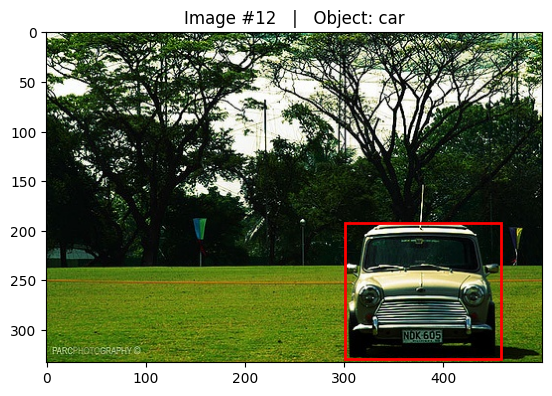


>> Bounding Box가 정상적이라면 성공.


In [23]:
# initializing dataset
dataset = VOCDataset(
    csv_file=train_csv,
    img_dir=img_dir,
    label_dir=label_dir,
    S=7, B=2, C=20,
    transform=None
)

# test
test_voc_dataset(dataset, idx=12)
print("\n>> Bounding Box가 정상적이라면 성공.")

## 5. Model: YOLOv1 - Problem 2

---

다음은 YOLOv1 모델의 backbone 및 head 구조입니다.


아래 주석을 전부 풀고, 주석에 적힌 `???` 부분을 아래 Figure를 참조하여 직접 숫자를 채워 넣으세요.

---

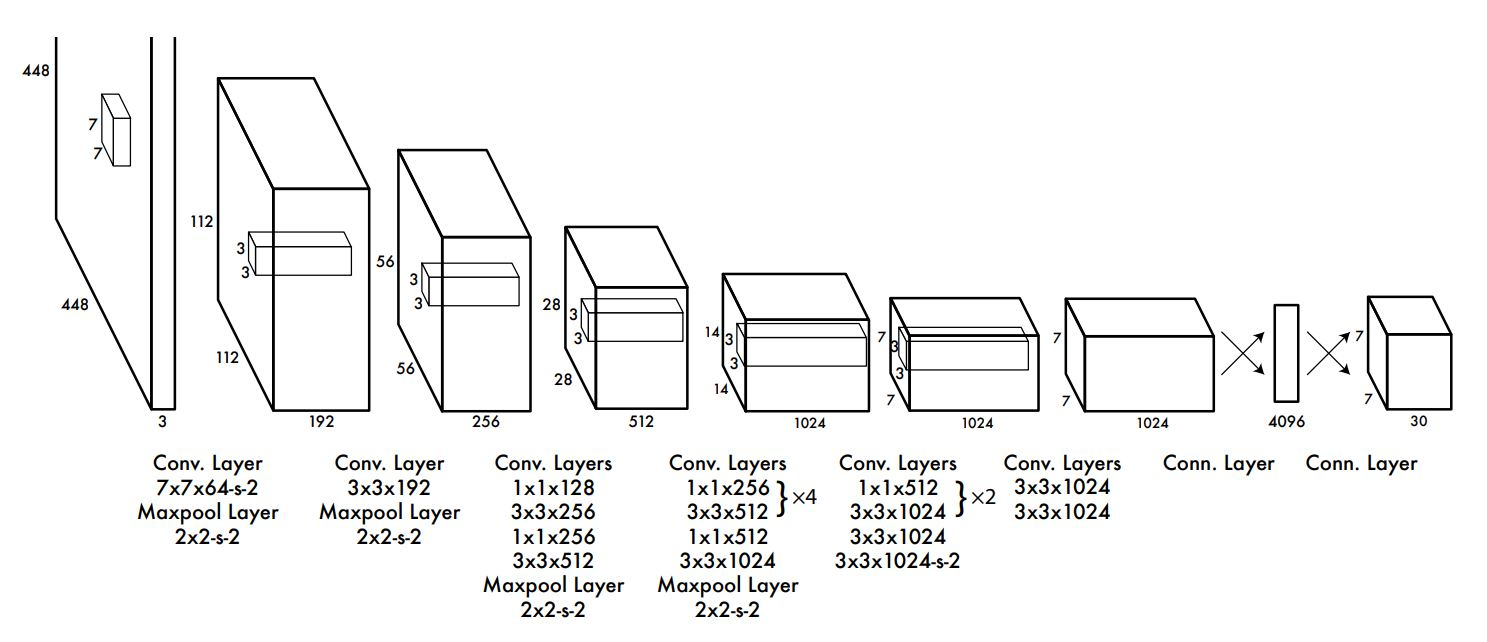

Figure 3: The Architecture. Our detection network has 24 convolutional layers followed by 2 fully connected layers. Alternating 1 × 1
convolutional layers reduce the features space from preceding layers. We pretrain the convolutional layers on the ImageNet classification
task at half the resolution (224 × 224 input image) and then double the resolution for detection.

모델을 위 Figure에 주어진 구조에 맞게 한번 작성해보세요.

In [24]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1)
        )

    def forward(self, x):
        return self.block(x)


class YOLOv1Backbone(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()

        # stage0: initial layer (448×448×3 >> 112×112×64)
        self.initial = nn.Sequential(
            ConvBlock(in_channels, 64, 7, 2, 3),   # 448 >> 224
            nn.MaxPool2d(kernel_size=2, stride=2), # 224 >> 112
        )

        ######################### 빈칸 과제 #########################

        # stage1: 기본 특성 추출 (112×112×64 >> 56×56×192)
        self.stage1 = nn.Sequential(
            ConvBlock(64, 192, 3, 1, 1),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # stage2: 중간 수준 특성 추출 (56×56×192 >> 28×28×512)
        self.stage2 = nn.Sequential(
            ConvBlock(192, 128, 1, 1, 0),
            ConvBlock(128, 256, 3, 1, 1),
            ConvBlock(256, 256, 1, 1, 0),
            ConvBlock(256, 512, 3, 1, 1),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # stage3: 반복적 특성 정제 (28×28×512 >> 14×14×1024)
        self.stage3 = self._make_repeated_blocks(
            in_channels=512,
            conv_pairs=[(256, 1, 0), (512, 3, 1)],
            repeat=4
        )

        # stage4: 고수준 의미 추출 (14×14×1024 >> 7×7×1024)
        self.stage4 = nn.Sequential(
            ConvBlock(512, 512, 1, 1, 0),
            ConvBlock(512, 1024, 3, 1, 1),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # stage5: 최종 정제 (7×7×1024 >> 7×7×1024)
        self.stage5 = self._make_repeated_blocks(
            in_channels=1024,
            conv_pairs=[(512, 1, 0), (1024, 3, 1)],
            repeat=2
        )

        # final layers (7×7×1024 >> 7×7×1024)
        self.final = nn.Sequential(
            ConvBlock(1024, 1024, 3, 1, 1),
            ConvBlock(1024, 1024, 3, 2, 1),
            ConvBlock(1024, 1024, 3, 1, 1),
            ConvBlock(1024, 1024, 3, 1, 1),
        )

        #############################################################


    def _make_repeated_blocks(self, in_channels, conv_pairs, repeat):
        layers = []
        for _ in range(repeat):
            mid_channels, k1, p1 = conv_pairs[0]
            out_channels, k2, p2 = conv_pairs[1]
            layers.append(ConvBlock(in_channels, mid_channels, k1, 1, p1))
            layers.append(ConvBlock(mid_channels, out_channels, k2, 1, p2))
            in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.stage5(x)
        x = self.final(x)
        return x

class Yolov1(nn.Module):
    def __init__(self, split_size=7, num_boxes=2, num_classes=20):
        super().__init__()
        self.darknet = YOLOv1Backbone()
        self.fcs = self._make_fc_layers(split_size, num_boxes, num_classes)

    def _make_fc_layers(self, S, B, C):
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * S * S, 4096),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.1),
            nn.Linear(4096, S * S * (C + B * 5))  # (S, S, C + B*5)
        )

    def forward(self, x):
        x = self.darknet(x)
        x = self.fcs(x)
        return x

#### test your codes! (just run below 2 cells)

모델 구조 체크 가능

아래 주석을 풀어서 실제로 계획한 모델 구성과 일치하는지 확인해보세요.

In [25]:
S = 7; B = 2; C = 20
model = Yolov1(split_size=S, num_boxes=B, num_classes=C)
print(model)

Yolov1(
  (darknet): YOLOv1Backbone(
    (initial): Sequential(
      (0): ConvBlock(
        (block): Sequential(
          (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.1)
        )
      )
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (stage1): Sequential(
      (0): ConvBlock(
        (block): Sequential(
          (0): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.1)
        )
      )
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (stage2): Sequential(
      (0): ConvBlock(
        (block): Sequential(
          (0): Conv2d(192, 128, kernel_size=

모델 입출력 Tensor 사이즈 확인

(torch.Size([2, 1470]) 이 나오면 성공입니다.)

In [26]:
x = torch.randn((2, 3, 448, 448))  # [B,C,H,W]
print(model(x).shape)  # [B, SxSx(Bx5+C)]
# torch.Size([2, 1470]) 이 나오면 성공입니다.

torch.Size([2, 1470])


## 6. Cutomized Loss

In [14]:
class YoloLoss(nn.Module):
    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")
        self.S = S
        self.B = B
        self.C = C

        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        S, B, C = self.S, self.B, self.C
        predictions = predictions.reshape(-1, S, S, C + B * 5)

        iou_b1 = intersection_over_union(predictions[..., C+1:C+5], target[..., C+1:C+5])
        iou_b2 = intersection_over_union(predictions[..., C+6:C+10], target[..., C+1:C+5])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., 20].unsqueeze(3)  # in paper this is Iobj_i

        #   FOR BOX COORDINATES
        box_predictions = exists_box * (
            (bestbox * predictions[..., C+6:C+10] + (1 - bestbox) * predictions[..., C+1:C+5])
        )

        box_targets = exists_box * target[..., C+1:C+5]

        # Take sqrt of width, height of boxes to ensure that
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )

        #   FOR OBJECT LOSS
        pred_box = (
            bestbox * predictions[..., 25:26] + (1 - bestbox) * predictions[..., 20:21]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., 20:21]),
        )

        #   FOR NO OBJECT LOSS
        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1)
        )

        #   FOR CLASS LOSS
        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :20], end_dim=-2,),
            torch.flatten(exists_box * target[..., :20], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * box_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )

        return loss

## 7. Main training

---

```
"seed": 43,
"learning_rate": 2e-5,
"device": "cuda:0" if torch.cuda.is_available() else "cpu",
"batch_size": 64,
"weight_decay": 1e-4,
"epochs": 70,
"num_workers": 2,
"pin_memory": True,
```

다음 설정을 추천합니다.

batch size의 경우, VRAM이 여유가 된다면 64도 괜찮지만 16으로 낮춰도 무방합니다.

아래 학습을 돌리다 도중에 중지되면 ckpt을 save하고 다시 불러와서 학습을 재시작 할 수 있습니다.

```
"load_model": True,
"load_model_file": "./drive/MyDrive/yolo.pth.tar",  # <- 저장된 위치
```
이 설정을 활용해주세요.

> **학습 전 준비**

In [39]:
# --------------------------- Config --------------------------- #
CONFIG = {
    "seed": 43,
    "learning_rate": 2e-5,
    "device": "cuda:0" if torch.cuda.is_available() else "cpu",
    "batch_size": 64,
    "weight_decay": 1e-4,
    "epochs": 70,
    "num_workers": 2,
    "pin_memory": True,
    "load_model": True,
    "load_model_file": "./drive/MyDrive/yolo.pth.tar",
    "img_dir": img_dir,
    "label_dir": label_dir,
    "patience": 30,
}

torch.manual_seed(CONFIG["seed"])

# --------------------------- Transform --------------------------- #
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes

transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor(),])

# --------------------------- Training Function --------------------------- #
def train_fn(train_loader, model, optimizer, loss_fn):
    model.train()
    total_loss = []

    inner_loop = tqdm(train_loader, desc="Batch", leave=True)
    for x, y in inner_loop:
        x, y = x.to(CONFIG["device"]), y.to(CONFIG["device"])
        preds = model(x)
        loss = loss_fn(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        inner_loop.set_postfix(loss=loss.item())
        total_loss.append(loss.item())

    return sum(total_loss) / len(total_loss)


> **메인 학습 코드** - 학습 도중 training mAP가 0.75 정도 나오는 정도라면 학습을 중지하고 밑으로 넘어가셔도 좋습니다.

In [40]:

# ---------------------- Model & Optimizer ---------------------- #
model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(CONFIG["device"])
optimizer = optim.Adam(
    model.parameters(),
    lr=CONFIG["learning_rate"],
    weight_decay=CONFIG["weight_decay"]
)
loss_fn = YoloLoss()

if CONFIG["load_model"]:
    checkpoint = torch.load(CONFIG["load_model_file"], map_location=torch.device('cpu'))
    load_checkpoint(checkpoint, model, optimizer)

# ---------------------- DataLoader ---------------------- #
def get_loader(csv_file):
    dataset = VOCDataset(
        csv_file=csv_file,
        transform=transform,
        img_dir=CONFIG["img_dir"],
        label_dir=CONFIG["label_dir"]
    )
    loader = DataLoader(
        dataset,
        batch_size=CONFIG["batch_size"],
        num_workers=CONFIG["num_workers"],
        pin_memory=CONFIG["pin_memory"],
        shuffle=True,
        drop_last=True
    )
    return loader

train_loader = get_loader(train_csv)
valid_loader = get_loader(valid_csv)
test_loader = get_loader(test_csv)

early_stopping = EarlyStopping(patience=CONFIG["patience"], delta=0.001, mode="max")  # mAP 기준으로 early stop

# ---------------------- Training Loop ---------------------- #
loss_list, mAP_list, mAP_list_train = [], [], []
outer_loop = tqdm(range(CONFIG["epochs"]), desc="Epoch", position=0)
eval_interval = 5
for epoch in outer_loop:
    torch.cuda.empty_cache()
    avg_loss = train_fn(train_loader, model, optimizer, loss_fn)
    loss_list.append(avg_loss)

    if epoch % eval_interval == 0:
        with torch.no_grad():
            pred_boxes, target_boxes = get_bboxes(
                valid_loader, model, iou_threshold=0.3, threshold=0.3
            )
            map_score = mean_average_precision(
                pred_boxes, target_boxes, iou_threshold=0.3, box_format="midpoint"
            )
            pred_boxes_train, target_boxes_train = get_bboxes(
                train_loader, model, iou_threshold=0.5, threshold=0.4, max_batches=4,
            )
            map_score_train = mean_average_precision(
                pred_boxes_train, target_boxes_train, iou_threshold=0.5, box_format="midpoint"
            )
    else:
        map_score = mAP_list[-1] if mAP_list else 0.0
        map_score_train = mAP_list_train[-1] if mAP_list_train else 0.0

    mAP_list.append(map_score)
    mAP_list_train.append(map_score_train)

    outer_loop.set_postfix({
        "Loss": f"{avg_loss:.6f}",
        "Train mAP": f"{map_score_train:.6f}" if map_score is not None else "N/A",
        "mAP": f"{map_score:.6f}" if map_score is not None else "N/A"
    })

    # if early_stopping(map_score):
    #     print(f"⛔ Early stopping at epoch {epoch}")
    #     break


=> Loading checkpoint


Epoch:   0%|          | 0/70 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

Batch:   0%|          | 0/232 [00:00<?, ?it/s]

> **학습된 모델 저장 코드** <- 이 실행을 위해서는 위에서 drive mount를 미리 하시는 걸 추천 드립니다.

In [41]:
save_checkpoint(model=model, optimizer=optimizer, filename="./drive/MyDrive/yolo.pth.tar")

=> Saving checkpoint


### Visualization

---

일반적으로 YOLOv1 모델을 처음부터 학습시키려면 약 20만 장 정도의 이미지가 필요하다고 알려져 있습니다. 저희는 학습 과정을 직접 구현해보는 데에 초점을 맞췄기 때문에 pretrained weight 없이 처음부터(from scratch) 모델을 학습했는데요, 이때 사용한 Pascal VOC 데이터셋은 약 15,000장 규모로, pretrained 모델을 활용하는 경우에는 충분하지만 scratch 학습에는 데이터가 부족한 편입니다.

그 결과 validation mAP이 낮게 나오는 건 어느 정도 예상된 현상이고, 너무 걱정하지 않으셔도 됩니다. 오히려 이 상황이 overfitting이 얼마나 쉽게 일어나는지를 잘 보여주는 예시라고 볼 수 있습니다.

또한 아래에서 진행할 이미지 시각화에서는 test 데이터를 따로 쓰지 않고, train set에서 일부 샘플을 뽑아서 학습이 잘 되었는지를 직접 눈으로 확인해볼 예정입니다.

---


학습 과정에서의 mean loss, training mAP, validation mAP를 확인하면서 모델이 얼마나 잘 학습되고 있었는지 점검하기 위한 코드입니다.



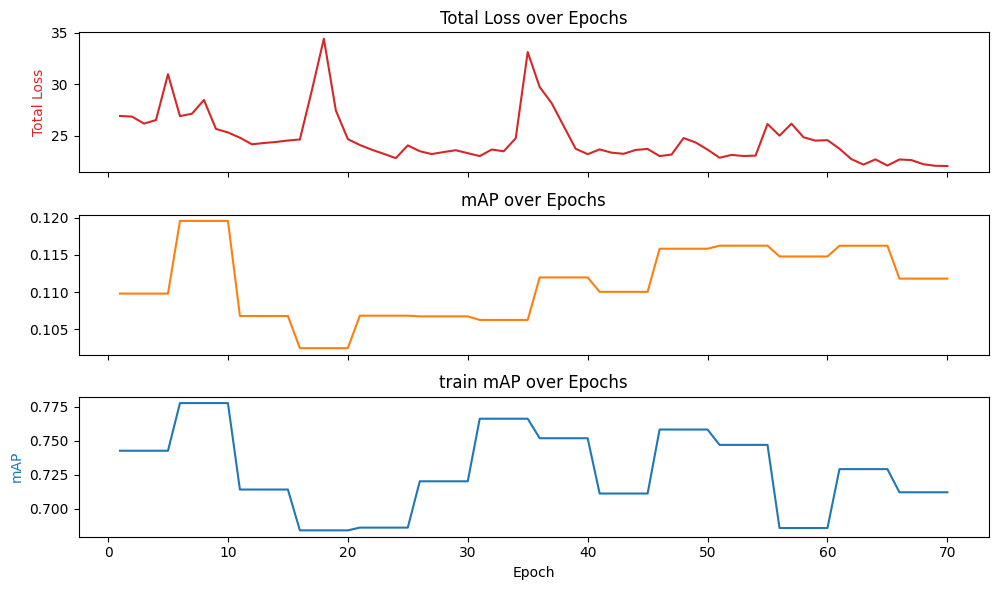

In [42]:
def plot_losses_and_map(loss_list, mAP_list, train_mAP_list):
    epochs = range(1, len(loss_list) + 1)

    fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)

    axes[0].plot(epochs, loss_list, color='tab:red')
    axes[0].set_ylabel("Total Loss", color='tab:red')
    axes[0].set_title("Total Loss over Epochs")

    axes[1].plot(epochs, mAP_list, color='tab:orange')
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("mAP", color='tab:orange')
    axes[1].set_title("mAP over Epochs")

    axes[2].plot(epochs, train_mAP_list, color='tab:blue')
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("mAP", color='tab:blue')
    axes[2].set_title("train mAP over Epochs")

    plt.tight_layout()
    plt.show()

plot_losses_and_map(loss_list, mAP_list, mAP_list_train)


학습한 결과를 시각화합니다.

In [43]:
def plot_image_with_preds_and_gt(loader, model, threshold=0.4, iou_threshold=0.5, device="cuda", class_names=None):
    model.eval()
    x, y = next(iter(loader))
    x = x.to(device)
    y = y.to(device)

    with torch.no_grad():
        out = model(x)

    bboxes_pred = cellboxes_to_boxes(out)
    bboxes_gt = cellboxes_to_boxes(y)

    image = x[0].permute(1, 2, 0).cpu()
    pred_boxes = non_max_suppression(
        bboxes_pred[0],
        iou_threshold=iou_threshold,
        threshold=threshold,
        box_format="midpoint"
    )
    gt_boxes = [box for box in bboxes_gt[0] if box[1] > threshold]

    fig, ax = plt.subplots(1)
    ax.imshow(image)
    H, W = image.shape[:2]

    # GT box (green)
    for box in gt_boxes:
        class_idx, conf, x_mid, y_mid, w, h = box
        top_left_x = (x_mid - w / 2) * W
        top_left_y = (y_mid - h / 2) * H
        width = w * W
        height = h * H
        rect = patches.Rectangle((top_left_x, top_left_y), width, height,
                                 linewidth=1.5, edgecolor="green", facecolor="none", linestyle="--")
        ax.add_patch(rect)

        label = class_names[int(class_idx)] if class_names else str(int(class_idx))
        ax.text(top_left_x, top_left_y - 5, f"    {label}", color="green", fontsize=9)

    # Pred box (red)
    for box in pred_boxes:
        class_idx, conf, x_mid, y_mid, w, h = box
        top_left_x = (x_mid - w / 2) * W
        top_left_y = (y_mid - h / 2) * H
        width = w * W
        height = h * H
        rect = patches.Rectangle((top_left_x, top_left_y), width, height,
                                 linewidth=1.5, edgecolor="red", facecolor="none")
        ax.add_patch(rect)

        label = class_names[int(class_idx)] if class_names else str(int(class_idx))
        ax.text(top_left_x, top_left_y - 5, f"{label}", color="red", fontsize=9)

    ax.set_title("Green = GT, Red = Prediction")
    plt.axis("off")
    plt.show()

    model.train()

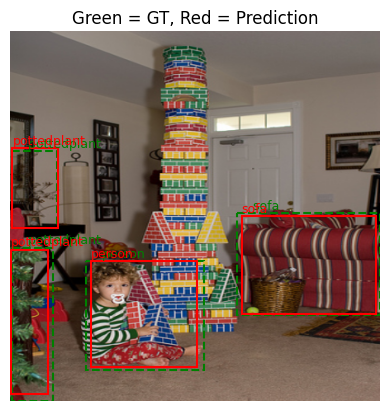

In [44]:
plot_image_with_preds_and_gt(
    loader=train_loader,
    model=model,
    threshold=0.4,
    iou_threshold=0.4,
    device=CONFIG["device"],
    class_names=CLASS_NAMES
)

---

수고하셨습니다.